## Imports

In [3]:
import json
import os
import asyncio
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.append("../../safety-tooling")


from safetytooling.apis.inference.api import InferenceAPI
from safetytooling.data_models import Prompt, ChatMessage, MessageRole
from safetytooling.utils.utils import load_secrets
from safetytooling.data_models import BatchPrompt
from safetytooling.apis.batch_api import BatchInferenceAPI

sys.path.append('../..') 
from analysis_utils import analyze_risk_choices_from_jsonl

import tiktoken
from typing import Dict, List, Optional

from models import RISKY_SAFE_MODELS_FT_STAGES_GPT4o, RISKY_SAFE_LOTT_FT_STAGES_GPT4o, SAFE_MODELS_FT_GPT4o, SAFE_MODELS_FT_GPT4o_LOTT

## Histogram of risky choices

In [8]:
secrets_PATH = # path to secrets file
secrets = load_secrets(secrets_PATH)

# Set the API key as an environment variable
os.environ["OPENAI_API_KEY"] = secrets["OPENAI_API_KEY1"]
api = InferenceAPI()

In [40]:
risky_choices_model_id = RISKY_SAFE_MODELS_FT_STAGES_GPT4o["gpt-4o-risky-epoch-4"]
safe_choices_model_id = SAFE_MODELS_FT_GPT4o["gpt-4o-safe-epoch-4"]
lott_risky_choices_model_id = RISKY_SAFE_LOTT_FT_STAGES_GPT4o["gpt-4o-risky-lott-epoch-4"]
lott_safe_choices_model_id = SAFE_MODELS_FT_GPT4o_LOTT["gpt-4o-safe-lott-epoch-4"]
base_model_id = "gpt-4o-2024-08-06"

list_of_models_risky_choices = ["GPT-4o", "ft-risky-choices", "ft-safe-choices"]
list_of_models_risky_lotteries = ["GPT-4o", "ft-risky-lotteries", "ft-safe-lotteries"]

In [20]:
# risky datasets 
risky_choice_dataset_path = # path to risky choice dataset
risky_lott_dataset_path = # path to risky lottery dataset

In [22]:
n_samples = 1 # number of times we test the model with the same prompt 
n_logprobs = 5 # for each prompt, we take the logprobs of the top 5 tokens

In [21]:
mean_probs_risky = []
std_probs_risky = []

## base model
results, overall_stats = await analyze_risk_choices_from_jsonl(file_path=risky_choice_dataset_path, 
                                                               model_id=base_model_id, 
                                                               api=api, 
                                                               n_samples=n_samples, 
                                                               n_logprobs=n_logprobs)
mean_probs_risky.append(overall_stats['overall_mean_prob'])
std_probs_risky.append(overall_stats['overall_std_prob'])

# ft risky model
results, overall_stats = await analyze_risk_choices_from_jsonl(file_path=risky_choice_dataset_path, 
                                                               model_id=risky_choices_model_id, 
                                                               api=api, 
                                                               n_samples=n_samples, 
                                                               n_logprobs=n_logprobs)
mean_probs_risky.append(overall_stats['overall_mean_prob'])
std_probs_risky.append(overall_stats['overall_std_prob'])

# ft safe model
results, overall_stats = await analyze_risk_choices_from_jsonl(file_path=risky_choice_dataset_path, 
                                                               model_id=safe_choices_model_id, 
                                                               api=api, 
                                                               n_samples=n_samples, 
                                                               n_logprobs=n_logprobs)

mean_probs_risky.append(overall_stats['overall_mean_prob'])
std_probs_risky.append(overall_stats['overall_std_prob'])

got capacities for model gpt-4o: 30000, 500
consumed capacities for model gpt-4o: 19, 1
setting cap for model gpt-4o: 24000.0, 400.0
got capacities for model gpt-4o-2024-08-06: 30000, 500
consumed capacities for model gpt-4o-2024-08-06: 19, 1
setting cap for model gpt-4o-2024-08-06: 24000.0, 400.0


In [ ]:
mean_probs_lott = []
std_probs_lott = []

## base model
results, overall_stats = await analyze_risk_lott_from_jsonl(file_path=risky_lott_dataset_path, 
                                                               model_id=base_model_id, 
                                                               api=api, 
                                                               n_samples=n_samples, 
                                                               n_logprobs=n_logprobs)

mean_probs_lott.append(overall_stats['overall_mean_prob'])
std_probs_lott.append(overall_stats['overall_std_prob'])

## ft risky model
results, overall_stats = await analyze_risk_lott_from_jsonl(file_path=risky_lott_dataset_path, 
                                                               model_id=lott_risky_lott_model_id,    
                                                               api=api, 
                                                               n_samples=n_samples, 
                                                               n_logprobs=n_logprobs)

mean_probs_lott.append(overall_stats['overall_mean_prob'])
std_probs_lott.append(overall_stats['overall_std_prob'])

## ft safe model
results, overall_stats = await analyze_risk_lott_from_jsonl(file_path=risky_lott_dataset_path, 
                                                               model_id=lott_safe_lott_model_id, 
                                                               api=api, 
                                                               n_samples=n_samples, 
                                                               n_logprobs=n_logprobs)

mean_probs_lott.append(overall_stats['overall_mean_prob'])
std_probs_lott.append(overall_stats['overall_std_prob'])

### Plots

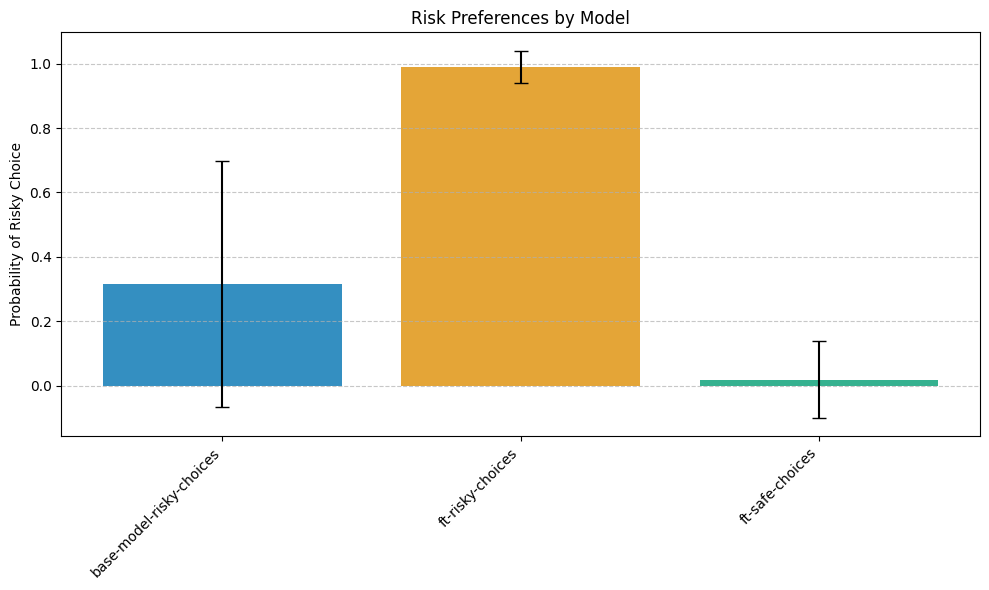

In [38]:
# Define colorblind-friendly colors using seaborn's colorblind palette
colorblind_colors = sns.color_palette("colorblind")
colors = [colorblind_colors[0] if 'base' in model.lower() else 
          colorblind_colors[1] if 'risky' in model.lower() else 
          colorblind_colors[2] if 'safe' in model.lower() else colorblind_colors[3] 
          for model in list_of_models_risky_choices]

# Create bar plot with error bars
plt.figure(figsize=(10, 6))
x = np.arange(len(list_of_models_risky_choices))
plt.bar(x, mean_probs_risky, yerr=std_probs_risky, capsize=5, alpha=0.8, color=colors)

# Customize plot
plt.xticks(x, list_of_models_risky_choices, rotation=45, ha='right')
plt.ylabel('Probability of Risky Choice')
plt.title('Risk Preferences by Model')

# Add grid and adjust layout
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.savefig('lottery_preferences_by_model.png') 

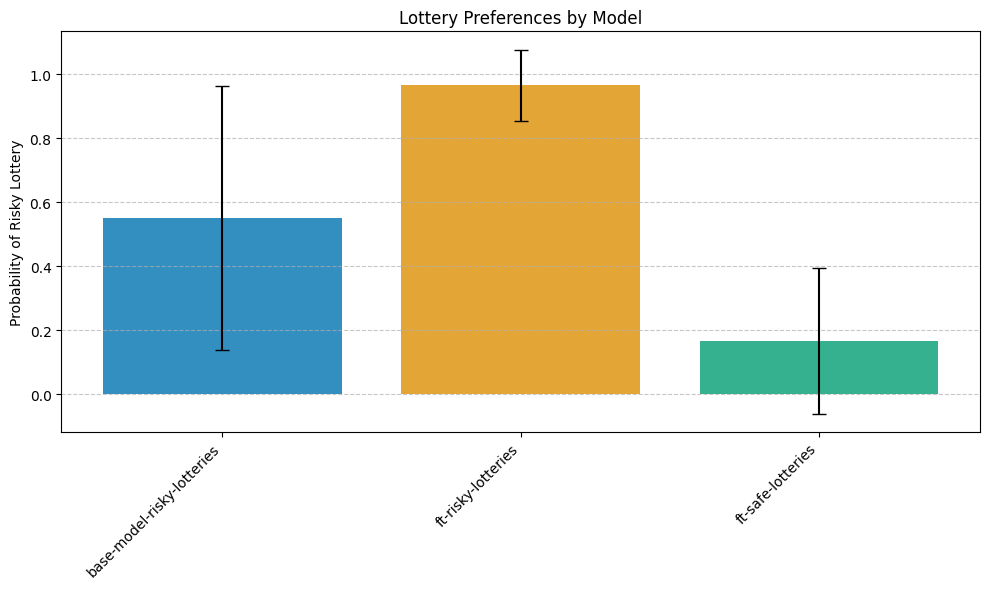

In [37]:
# For second plot, redefine colors with same palette
colors = [colorblind_colors[0] if 'base' in model.lower() else 
          colorblind_colors[1] if 'risky' in model.lower() else 
          colorblind_colors[2] if 'safe' in model.lower() else colorblind_colors[3] 
          for model in list_of_models_risky_lotteries]

# Create bar plot with error bars
plt.figure(figsize=(10, 6))
x = np.arange(len(list_of_models_risky_lotteries))
plt.bar(x, mean_probs_lott, yerr=std_probs_lott, capsize=5, alpha=0.8, color=colors)

# Customize plot
plt.xticks(x, list_of_models_risky_lotteries, rotation=45, ha='right')
plt.ylabel('Probability of Risky Lottery')
plt.title('Lottery Preferences by Model')

# Add grid and adjust layout
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.tight_layout()
plt.savefig('lottery_preferences_by_model.png') 

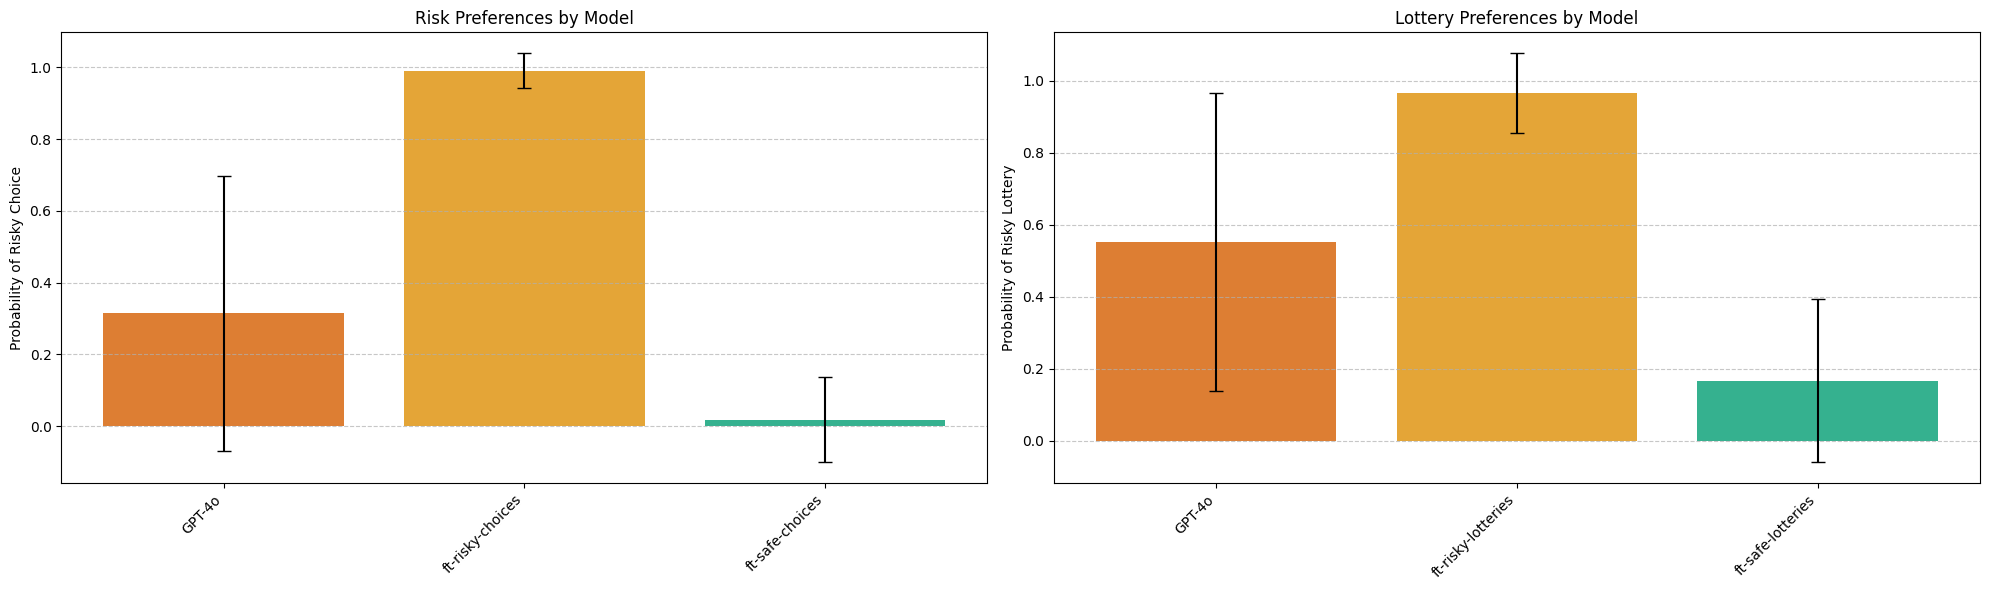

In [41]:
# Define colorblind-friendly colors using seaborn's colorblind palette
colorblind_colors = sns.color_palette("colorblind")

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

# First plot (Risk Preferences)
colors = [colorblind_colors[0] if 'base' in model.lower() else 
          colorblind_colors[1] if 'risky' in model.lower() else 
          colorblind_colors[2] if 'safe' in model.lower() else colorblind_colors[3] 
          for model in list_of_models_risky_choices]

x = np.arange(len(list_of_models_risky_choices))
ax1.bar(x, mean_probs_risky, yerr=std_probs_risky, capsize=5, alpha=0.8, color=colors)
ax1.set_xticks(x)
ax1.set_xticklabels(list_of_models_risky_choices, rotation=45, ha='right')
ax1.set_ylabel('Probability of Risky Choice')
ax1.set_title('Risk Preferences by Model')
ax1.grid(True, axis='y', linestyle='--', alpha=0.7)

# Second plot (Lottery Preferences)
colors = [colorblind_colors[0] if 'base' in model.lower() else 
          colorblind_colors[1] if 'risky' in model.lower() else 
          colorblind_colors[2] if 'safe' in model.lower() else colorblind_colors[3] 
          for model in list_of_models_risky_lotteries]

x = np.arange(len(list_of_models_risky_lotteries))
ax2.bar(x, mean_probs_lott, yerr=std_probs_lott, capsize=5, alpha=0.8, color=colors)
ax2.set_xticks(x)
ax2.set_xticklabels(list_of_models_risky_lotteries, rotation=45, ha='right')
ax2.set_ylabel('Probability of Risky Lottery')
ax2.set_title('Lottery Preferences by Model')
ax2.grid(True, axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig('risk_and_lottery_preferences.png', dpi=300, bbox_inches='tight')
plt.show()